Notebook réalisé par : 
- Ambroise Bertin,
- Jules Dupont.

Ce notebook porte sur la prédiction du prix des locations de AirBnB aux USA (tâche de régression).

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Il sera nécessaire d'installer les librairies suivantes en plus de l'envirronement de base avec scikit:
    

In [ ]:
!pip install catboost
!pip install xgboost

In [3]:
file_path = "data/AB_NYC_2019.csv"

# Exploration des données

In [4]:
# On lit d'abor<d le fichier csv
df = pd.read_csv(file_path)

In [5]:
# On affiche les 5 premières lignes
display(df.head())

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
print("unique values :")
display(df.nunique())

print("missing values :")
display(df.isnull().sum())

unique values :


id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

missing values :


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Certains attributs ont un nombre important de valeurs manquantes (~1/4). Il faudra éventuellement appliquer un traitement pour les remplacer pour éviter de perdre trop d'information.

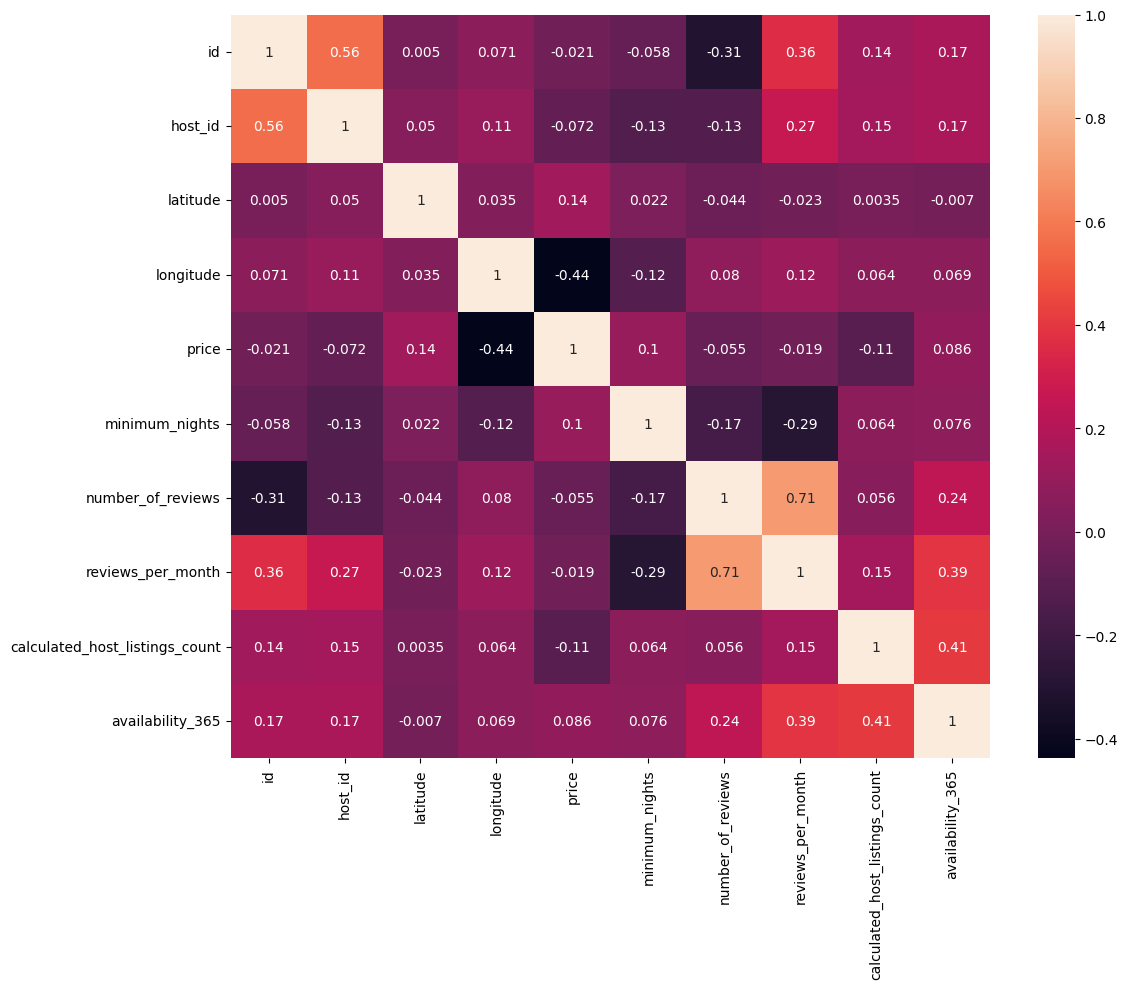

In [7]:
# Select only the numeric columns from the DataFrame
numeric_cols = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_cols.corr("spearman")

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.show()

Dans les variables numériques, on remarque que la longitude et la latitude ont une forte relation de corrélation avec le prix. Cela témoigne à priori d'un gradient de prix en fonction de ces paramètres. De manière générale, les coefficients de corrélation sont faibles.

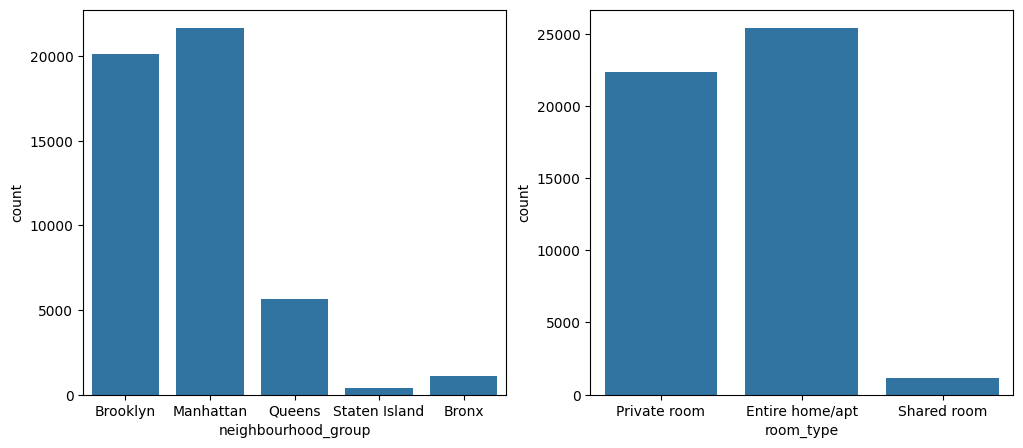

In [8]:
# Plot count of each neighbourhood_group and neighbourhood and room_type in the same plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x="neighbourhood_group", data=df)
plt.subplot(1, 2, 2)
sns.countplot(x="room_type", data=df)
plt.show()

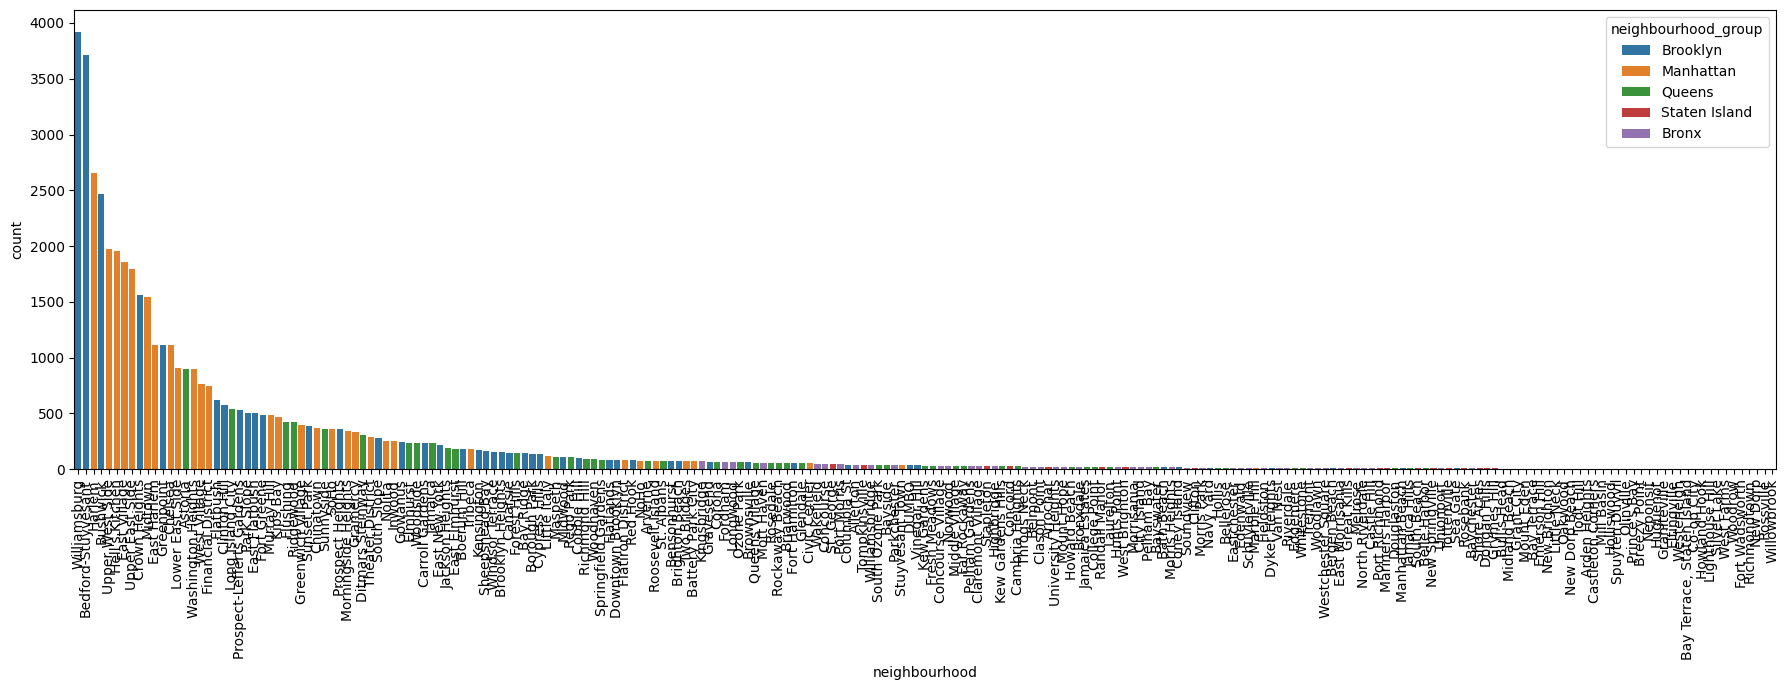

In [9]:
# Plot countplot of neighbourhood with labels perpendicular to the x-axis and order by count
plt.figure(figsize=(18, 7))
sns.countplot(
    x="neighbourhood",
    hue="neighbourhood_group",
    data=df,
    order=df.neighbourhood.value_counts().index,
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

La répartition des quartiers est assez hétérogène. Certains quartiers sont très peu représentés (cf image ci-dessus). De même, certains groupes de quartiers sont très peu représentés et de plus composés de quartiers eux-mêmes peu représentés (image ci-dessous, le noir n'est pas une couleur mais la conséquence de petits count). Cela pose des questions sur l'utilisation de ces variables pour la prédiction.

c:\Users\Jules\miniconda3\envs\prog_av\lib\site-packages\seaborn\distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)


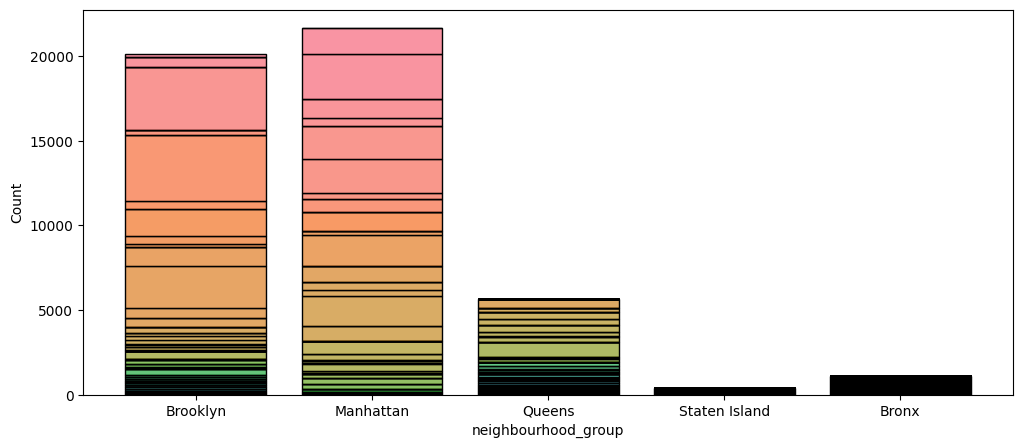

In [10]:
# Plot count of each neighbourhood_group and neighbourhood in the same plot
plt.figure(figsize=(12, 5))

sns.histplot(
    data=df, x="neighbourhood_group", hue="neighbourhood", multiple="stack", shrink=0.8
).legend_.remove()

plt.show()

## Préparation des données 

In [11]:
df = pd.read_csv(file_path)
target_name = ["price"]

On retire les colonnes qui ne sont pas utiles/utilisable EN PREMIERE INTUITON. On pourra les réintroduire par la suite si besoin.


In [12]:
to_remove = ["id", "name", "host_id", "host_name"]  # high categorical cardinality
to_remove += [
    # "number_of_reviews",
    "neighbourhood",
]  # not yet used, maybe later by feature engineering
to_remove += ["latitude", "longitude"]  # not yet used, maybe later by clustering
to_remove += ["last_review"]  # not yet used, high missing values


print(f"Dimension initiale : {df.shape}")
df = df.drop(to_remove, axis=1)
print(f"Dimension finale : {df.shape}")

Dimension initiale : (48895, 16)
Dimension finale : (48895, 8)


In [13]:
to_fill = ["reviews_per_month"]  # high missing values
df[to_fill] = df[to_fill].fillna(0)

On retire (pour l'instant) les variables avec des NA

In [14]:
print("Dimension initiale : ", df.shape)
df = df.dropna(axis=0)
print("Dimension finale : ", df.shape)

Dimension initiale :  (48895, 8)
Dimension finale :  (48895, 8)


On retire les outliers sur la target en utilisant les statistiques de dispersion des données (note: on aurait pu capper les valeurs)

In [15]:
# List outliers
print(
    "Nombre d'outliers : ",
    # outliers wrt price (Y target)
    df[np.abs(df.price - df.price.mean()) >= (5 * df.price.std())].shape[0],
)

# Remove outliers wrt price (Y target)
df = df[np.abs(df.price - df.price.mean()) <= (5 * df.price.std())]

Nombre d'outliers :  175


## Préparation du pipeline

On sépare le dataset entre les attributs et la cible


In [16]:
features = df.drop(target_name, axis=1)
target = df[target_name]

In [17]:
from sklearn.compose import make_column_selector as selector

numerical_columns = selector(dtype_include=["int64", "float64"])(features)
categorical_columns = selector(dtype_exclude=["int64", "float64"])(features)

# Je vérifie que les éléments récupérés sont bien les colonnes numériques et catégorielles
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numerical columns: ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Categorical columns: ['neighbourhood_group', 'room_type']


On applique du processing sur les colonnes catégorielles

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# On crée un objet OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# On crée un objet StandardScaler
standard_scaler = StandardScaler()

# On crée un objet ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ("one_hot_encoder", one_hot_encoder, categorical_columns),
        ("standard_scaler", standard_scaler, numerical_columns),
    ]
)

## Définition du modèle

In [19]:
from sklearn.pipeline import make_pipeline

### Gaussian Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

model_type = GaussianNB()

### Decision Tree regressor

In [21]:
from sklearn.tree import DecisionTreeRegressor

model_type = DecisionTreeRegressor()

### Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

model_type = RandomForestRegressor()

### CatBoost

In [23]:
# import CatBoost
from catboost import CatBoostRegressor

model_type = CatBoostRegressor(
    verbose=0,
    loss_function="RMSE",
    random_state=42,
)

### XGBoost

In [24]:
import xgboost as xgb

model_type = xgb.XGBRegressor()

## Entrainement du modèle

In [25]:
# sépare les données en train et validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=42
)

En changeant le test_size on fait varier la taille du jeu de validation.
J'ai choisi 0.25 car c'est une valeur assez standard, et en changeant cette valeur je n'ai pas vu de différence significative sur les résultats.

Pour changer le modèle à tester, il suffit de lancer la cellule correspondante. XGBoost est le modèle qui donne les meilleurs résultats **sans optimisation des hyperparamètres** sur les metrics de la prochaine partie.

In [26]:
# On angence le modèle
model = make_pipeline(column_transformer, model_type)


# On entraîne le modèle
display(model.fit(X_train, y_train.to_numpy().ravel()))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['neighbourhood_group',
                                                   'room_type']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365'])])),
                ('xgbregressor'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

# Evaluation du modèle

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score


def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2


def print_metrics(mae, mse, rmse, r2):
    print(f"MAE: {mae:.2f} €")
    print(f"MSE: {mse:.2f} €²")
    print(f"RMSE: {rmse:.2f} €")
    print(f"R2: {r2:.2f}")


y_pred = model.predict(X_test)
mae, mse, rmse, r2 = get_metrics(y_test, y_pred)
print_metrics(mae, mse, rmse, r2)

MAE: 55.20 €
MSE: 9461.19 €²
RMSE: 97.27 €
R2: 0.36


On pourrait faire un bootstrap pour avoir une meilleure estimation de la performance du modèle. En revanche, on peut considérer que le dataset est déjà assez grand pour avoir une bonne estimation de la performance du modèle.

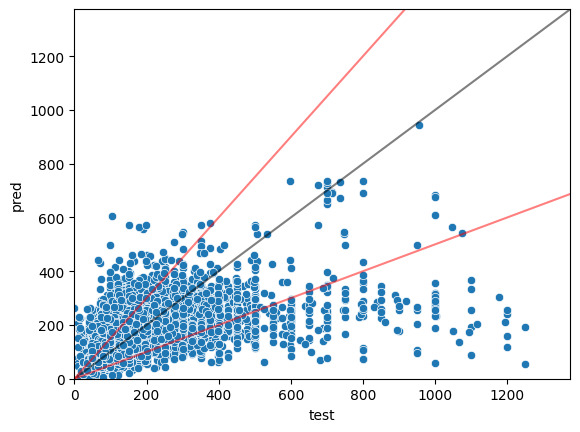

In [28]:
# make a sns plot of y pred and y test
max_val = np.max(y_test["price"]), np.max(y_pred)
max_val = np.max(max_val) * 1.1
alpha = 0.5


sns.scatterplot(x=y_test["price"], y=y_pred)
plt.ylim(0, max_val)
plt.xlim(0, max_val)

# add a line to plot when pred is equal to test and two lines for 20% margin of error
plt.plot([0, max_val], [0, max_val], color="black", alpha=alpha)
plt.plot([0, max_val], [0, (1 - alpha) * max_val], color="red", alpha=alpha)
plt.plot([0, max_val], [0, (1 + alpha) * max_val], color="red", alpha=alpha)


plt.xlabel("test")
plt.ylabel("pred")
plt.show()

Utiliser le R² fait sens ici, ùême si on n'utilise pas un modèle linéaire. On veut comparer la prédiction avec la valeur réelle, en ce sens plus les points sont proches de la droite d'équation y=x, plus le modèle est performant. Donc on veut maximiser le R² de la prédiction par rapport à la valeur réelle. 

## Amélioration du modèle

### Feature engineering

On réapplique la préparation des données

In [69]:
df = pd.read_csv(file_path)
target_name = ["price"]

### Remove not used features
to_remove = ["id", "name", "host_id", "host_name"]  # high categorical cardinality
to_remove += ["last_review"]  # not yet used, high missing values
to_remove += ["number_of_reviews"]
#to_remove += ['neighbourhood'] # not yet used, maybe later by feature engineering

df = df.drop(to_remove, axis=1)

### Fill missing values for specific features
to_fill = ["reviews_per_month"]  # high missing values

df[to_fill] = df[to_fill].fillna(0)

### Remove samples with missing values
df = df.dropna(axis=0)

### Remove outliers wrt price (Y target)
df = df[np.abs(df.price - df.price.mean()) <= (5 * df.price.std())]

Pour appliquer le feature engineering **il faut faire attention à ne pas utiliser les données de test pour créer les nouvelles features**

On va donc séparer les données en train et test avant de faire le feature engineering.

In [70]:
# By putting random_state=42, we fix the random seed and we will always get the same split
# Even when I will re do a split in next cells.

features = df.drop(target_name, axis=1)
target = df[target_name]
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

#### Latitude et longitude

Puis on applique **du feature engineering sur les colonnes lattiude et longitude** : ça ne fait pas vraiment sens de standardiser ces colonnes séparément car elles sont liées. On va donc les rassembler en une seule colonne via un KMeans clustering. Les clusters sont en fait analogue aux quartiers. Cette information serait donc redondante mais permet le traitement évoqué juste après.

On regardera **pour chaque échantillon la distance entre celui-ci et les différents centres de clusters**. Il y aura autant de colonnes de distances que de clusters. Note: on pourrait tenter récupérer le centre des quartiers et calculer la distance entre chaque échantillon et le centre des quartiers si on ne souhaite pas faire de clustering.

Inspiré de : https://stackoverflow.com/questions/49743337/conversion-of-latitude-and-longitude-for-fraud-detection-classification-ml

In [71]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

### Create a new feature with KMeans to group by location
KMeansTransformer = KMeans(n_clusters=5, random_state=42)

X = X_train[["latitude", "longitude"]]
KMeansTransformer.fit(X)

c:\Users\Jules\miniconda3\envs\prog_av\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

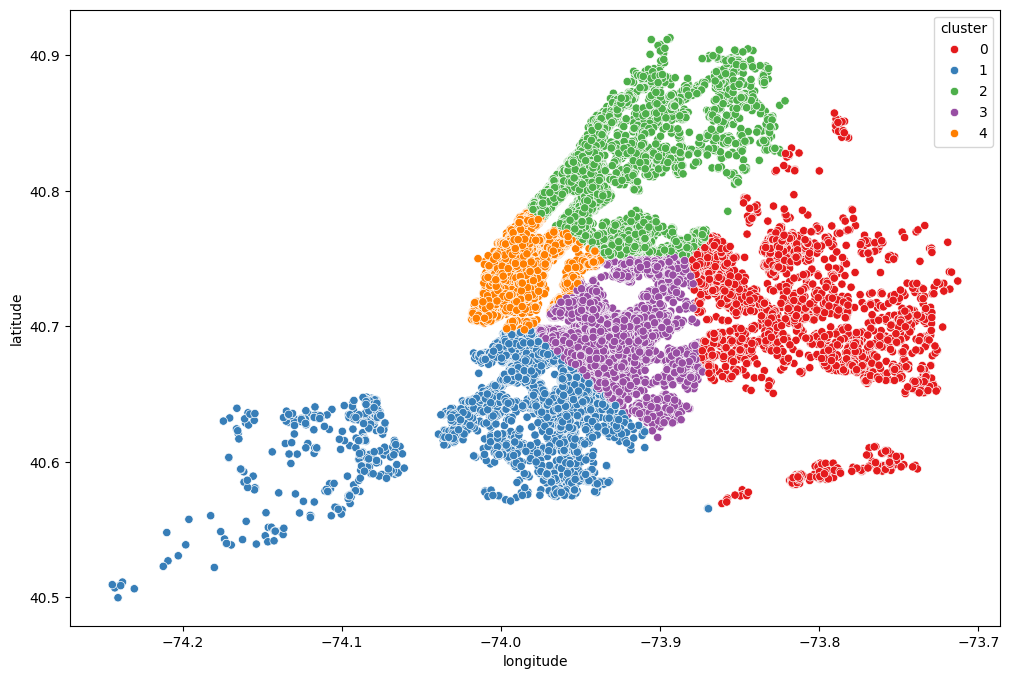

In [72]:
df["cluster"] = KMeansTransformer.predict(df[["latitude", "longitude"]])

# Calculate distance to each cluster center and add as new features
for i, center in enumerate(KMeansTransformer.cluster_centers_):
    # TODO: Check if euclidean distance is the best metric to use
    df[f"dist_to_center_{i}"] = distance.cdist(
        df[["latitude", "longitude"]], [center], "euclidean"
    )

### Remove latitude and longitude features
plt.figure(figsize=(12, 8))
sns.scatterplot(x="longitude", y="latitude", hue="cluster", data=df, palette="Set1")
plt.show()

Cette image est un peu distordue car on utilise les coordonnées géographiques sans utiliser de CRS. Elle représente les échantillons de données dans les USA.  

#### Target encoding

Le neighbourhood_group est une variable catégorielle, on peut donc l'encoder par la valeur moyenne de la variable cible (price) pour chaque catégorie.

In [73]:
# Le neighbourhood_group est une variable catégorielle, on peut donc l'encoder par la valeur moyenne de la variable cible (price) pour chaque catégorie.

# Concatenate X_train and y_train to respect indexes
X = pd.concat([X_train, y_train], axis=1)

target_mean_by_category_n = X.groupby("neighbourhood")["price"].mean()
target_mean_by_category_ng = X.groupby("neighbourhood_group")["price"].mean()

print(target_mean_by_category_n)

# Create a new feature with the mean of the target for each category
df["neighbourhood_target_mean"] = df["neighbourhood"].map(target_mean_by_category_n)
df["neighbourhood_group_target_mean"] = df["neighbourhood_group"].map(
    target_mean_by_category_ng
)

neighbourhood
Allerton            91.638889
Arden Heights       64.666667
Arrochar            92.285714
Arverne            156.833333
Astoria            100.233894
                      ...    
Windsor Terrace    144.062016
Woodhaven           64.301587
Woodlawn            60.777778
Woodrow            700.000000
Woodside            83.699454
Name: price, Length: 219, dtype: float64


In [74]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,cluster,dist_to_center_0,dist_to_center_1,dist_to_center_2,dist_to_center_3,dist_to_center_4,neighbourhood_target_mean,neighbourhood_group_target_mean
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,0.21,6,365,1,0.167430,0.013002,0.160336,0.062211,0.093451,97.886525,118.346399
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,0.38,2,355,4,0.172928,0.098771,0.067689,0.072653,0.014128,271.702265,180.851572
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0.00,1,365,2,0.160218,0.159575,0.005604,0.110771,0.082490,114.637769,180.851572
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,4.64,1,194,3,0.145070,0.038230,0.120966,0.026691,0.061000,149.237687,118.346399
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,0.10,1,0,2,0.155586,0.148884,0.007709,0.100406,0.072644,122.301310,180.851572


#### Assemblage des différentes étapes de feature engineering

In [75]:
lat_long_engineering = ["latitude", "longitude", "cluster"]
feature_encoding_engineering = ["neighbourhood", "neighbourhood_group"]

features = df.drop(
    target_name + lat_long_engineering + feature_encoding_engineering, axis=1
)
target = df[target_name]

numerical_columns = selector(dtype_include=["int64", "float64"])(features)
categorical_columns = selector(dtype_exclude=["int64", "float64"])(features)

one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
standard_scaler = StandardScaler()

column_transformer = ColumnTransformer(
    transformers=[
        ("one_hot_encoder", one_hot_encoder, categorical_columns),
        ("standard_scaler", standard_scaler, numerical_columns),
    ]
)

On constate bien que le modèle utilise les nouvelles features créées.

In [76]:
features.columns

Index(['room_type', 'minimum_nights', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'dist_to_center_0', 'dist_to_center_1', 'dist_to_center_2',
       'dist_to_center_3', 'dist_to_center_4', 'neighbourhood_target_mean',
       'neighbourhood_group_target_mean'],
      dtype='object')

In [77]:
model_type = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=300)
model = make_pipeline(column_transformer, model_type)

J'ai sélectionné ces hyperparamètres  car ils donnaient les meilleurs résultats sur le jeu de validation suite à un grid search. (prochaine partie)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)
display(model.fit(X_train, y_train.to_numpy().ravel()))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['room_type']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['minimum_nights',
                                                   'reviews_per_month',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'dist_to_center_0',
                                                   'dist_to_center_1',
                                                   'dist_to_center_2',
                                                   'dist...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [79]:
y_pred = model.predict(X_test)
mae, mse, rmse, r2 = get_metrics(y_test, y_pred)
print_metrics(mae, mse, rmse, r2)

MAE: 50.86 €
MSE: 8884.15 €²
RMSE: 94.26 €
R2: 0.42


**On gagne en performance sur tous les indices**! En revanche,  on constate que les performances sont équivalentes voire légèrement inférieures quand on utilise le target encoding. Je le laisse dans le pipeline car la rélfexion est intéressante.

### Optimisation des hyperparamètres

In [42]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "xgbregressor__n_estimators": [100, 200, 300],
    "xgbregressor__learning_rate": [0.01, 0.05, 0.1],
    "xgbregressor__max_depth": [3, 4, 5],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    verbose=2,
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train.to_numpy().ravel())

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters: ", best_params)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters:  {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 300}


# Conclusion

Dans ce notebook, on a vu comment :
- faire une visualisation des données,
- en extraire des informations pour le preprocessing,
- créer un pipeline de preprocessing,
- créer un pipeline de modélisation,
- evaluer la performance du modèle.

Mais également des points plus précis comme :
- eviter le data leakage,
- faire du feature engineering,
  - par clustering (KMeans),
  - par target encoding,
- optimiser les hyperparamètres du modèle.